Trabajo Práctico 2 - Embeddings

1.    Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.

2.   Probar términos de interés y explicar similitudes en el espacio de embeddings.

3. Intentar plantear y probar tests de analogías. Graficar los embeddings
resultantes.

4. Sacar conclusiones.


In [1]:
#Vamos a usar el Twitter dataset, extraído de Kaggle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

import re

import tensorflow as tf
from tensorflow import keras
from keras import preprocessing

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
csv_path='/content/drive/MyDrive/NLP CEIA/twitter_dataset_TP2.csv'
twitter_dataset = pd.read_csv(csv_path)
twitter_dataset.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [3]:
twitter_dataset = twitter_dataset['Text']
twitter_dataset.head()

,Text
0,Party least receive say or single. Prevent pre...
1,Hotel still Congress may member staff. Media d...
2,Nice be her debate industry that year. Film wh...
3,Laugh explain situation career occur serious. ...
4,Involve sense former often approach government...


In [4]:
#Acá Chat GPT sugiere otro código para el preprocesamiento, dado que el código de la clase está deprecado

# Función para limpiar y tokenizar texto
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Separar palabras por espacios
    tokens = text.split()
    return tokens

# Aplicar la función de preprocesamiento
twitter_dataset_gpt = twitter_dataset.apply(preprocess_text)

twitter_dataset_gpt.head()

,Text
0,"[party, least, receive, say, or, single, preve..."
1,"[hotel, still, congress, may, member, staff, m..."
2,"[nice, be, her, debate, industry, that, year, ..."
3,"[laugh, explain, situation, career, occur, ser..."
4,"[involve, sense, former, often, approach, gove..."


In [5]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [6]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=30,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1, alpha=0.025, min_alpha=0.0001)           # modelo 0:CBOW  1:skipgram


#Cuando lo entrené más adelante me dio el error : Effective 'alpha' higher than previous training cycles, asique establezco el alpha

In [7]:
w2v_model.build_vocab(twitter_dataset_gpt)

In [8]:
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 10000


In [9]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 971


In [10]:
print(w2v_model.wv.index_to_key)

['hard', 'tax', 'out', 'add', 'when', 'high', 'maybe', 'my', 'food', 'yourself', 'yard', 'senior', 'forget', 'success', 'scene', 'job', 'young', 'man', 'edge', 'boy', 'them', 'agree', 'teach', 'exactly', 'check', 'same', 'growth', 'piece', 'majority', 'want', 'dog', 'if', 'instead', 'level', 'receive', 'under', 'team', 'able', 'age', 'soldier', 'though', 'he', 'wear', 'nearly', 'cell', 'dark', 'room', 'serve', 'accept', 'have', 'meeting', 'voice', 'paper', 'light', 'west', 'number', 'herself', 'successful', 'tv', 'rule', 'direction', 'long', 'or', 'account', 'play', 'goal', 'work', 'we', 'term', 'try', 'good', 'send', 'deal', 'both', 'site', 'run', 'finish', 'ahead', 'son', 'since', 'rise', 'image', 'establish', 'situation', 'base', 'middle', 'hotel', 'tend', 'necessary', 'police', 'during', 'who', 'owner', 'enjoy', 'conference', 'go', 'anyone', 'everyone', 'part', 'the', 'culture', 'pretty', 'generation', 'relationship', 'husband', 'of', 'record', 'speak', 'south', 'trial', 'personal'

In [11]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback

w2v_model.train(twitter_dataset_gpt,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 3607031.5
Loss after epoch 1: 2964730.5
Loss after epoch 2: 2957406.0
Loss after epoch 3: 2942062.0
Loss after epoch 4: 2944968.0
Loss after epoch 5: 2973786.0
Loss after epoch 6: 2996366.0
Loss after epoch 7: 2992728.0
Loss after epoch 8: 2988742.0
Loss after epoch 9: 2990944.0
Loss after epoch 10: 2985756.0
Loss after epoch 11: 3853800.0
Loss after epoch 12: 3918940.0
Loss after epoch 13: 3918628.0
Loss after epoch 14: 3917340.0
Loss after epoch 15: 3921508.0
Loss after epoch 16: 3919208.0
Loss after epoch 17: 3918840.0
Loss after epoch 18: 3914904.0
Loss after epoch 19: 2482008.0


(6797060, 6797060)

In [12]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["outside"], topn=20)

[('head', 0.7388399839401245),
 ('do', 0.7277103066444397),
 ('amount', 0.7235565781593323),
 ('appear', 0.7084537744522095),
 ('within', 0.6912365555763245),
 ('huge', 0.6844443678855896),
 ('half', 0.6760700345039368),
 ('board', 0.6666175127029419),
 ('heart', 0.6634576320648193),
 ('special', 0.6602362990379333),
 ('account', 0.6595757007598877),
 ('finish', 0.6576652526855469),
 ('attack', 0.6569046974182129),
 ('one', 0.6541475057601929),
 ('west', 0.6485022306442261),
 ('agreement', 0.6460484862327576),
 ('forget', 0.644523024559021),
 ('serve', 0.6427106261253357),
 ('become', 0.6373761296272278),
 ('citizen', 0.6362744569778442)]

In [15]:
w2v_model.wv.index_to_key.index('inside')

410

In [17]:
w2v_model.wv.similarity('outside', 'inside')

0.5274798

In [42]:
w2v_model.wv.index_to_key.index('up')

252

In [43]:
w2v_model.wv.index_to_key.index('down')

306

In [44]:
w2v_model.wv.similarity('up', 'down')

0.31847852

In [47]:
result = w2v_model.wv.most_similar(positive=['up', 'outside'], negative=['down'], topn=15)
print(result)

[('avoid', 0.649125337600708), ('their', 0.6248734593391418), ('resource', 0.6024953126907349), ('easy', 0.590479850769043), ('night', 0.5902066826820374), ('example', 0.5787444114685059), ('seem', 0.5781599283218384), ('cause', 0.571022629737854), ('for', 0.5471389293670654), ('wall', 0.5440323948860168), ('book', 0.5400214195251465), ('eat', 0.5374155044555664), ('church', 0.536407470703125), ('protect', 0.5339237451553345), ('phone', 0.5333543419837952)]


In [18]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["government"], topn=20)

[('something', 0.7877017259597778),
 ('together', 0.7754973769187927),
 ('perform', 0.7722503542900085),
 ('consumer', 0.7570891976356506),
 ('prepare', 0.7469326853752136),
 ('our', 0.7360191941261292),
 ('media', 0.7306116223335266),
 ('accept', 0.700918436050415),
 ('radio', 0.7009112238883972),
 ('late', 0.6982126832008362),
 ('authority', 0.6957319974899292),
 ('her', 0.6955536007881165),
 ('get', 0.6939147710800171),
 ('stage', 0.6904224753379822),
 ('true', 0.6852931380271912),
 ('heart', 0.6834151148796082),
 ('agent', 0.6824710369110107),
 ('on', 0.6811773180961609),
 ('six', 0.680622935295105),
 ('support', 0.6788222789764404)]

In [48]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["tax"], topn=10)

[('positive', 0.7731925249099731),
 ('probably', 0.704338788986206),
 ('reveal', 0.6988759636878967),
 ('serious', 0.6873326897621155),
 ('movie', 0.6872841119766235),
 ('choice', 0.6732737421989441),
 ('back', 0.6705653071403503),
 ('central', 0.6687703132629395),
 ('fear', 0.6638190150260925),
 ('situation', 0.6624077558517456)]

In [49]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["inside"], topn=10)

[('include', -0.08478401601314545),
 ('daughter', -0.11602944880723953),
 ('member', -0.13439790904521942),
 ('stay', -0.13804051280021667),
 ('common', -0.1523265689611435),
 ('simple', -0.15992729365825653),
 ('democratic', -0.17184430360794067),
 ('listen', -0.17516052722930908),
 ('morning', -0.18026871979236603),
 ('carry', -0.1803985834121704)]

In [21]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["agree"], topn=10)

[('shoulder', -0.09081003814935684),
 ('save', -0.09994770586490631),
 ('need', -0.11319857835769653),
 ('other', -0.13180318474769592),
 ('for', -0.13430996239185333),
 ('break', -0.1351877897977829),
 ('attorney', -0.14089439809322357),
 ('item', -0.14821743965148926),
 ('customer', -0.14955535531044006),
 ('hospital', -0.15501756966114044)]

In [22]:
#Buscando en internet, es un dataset de polaridad, tiene tres columnas: polarity, title, review
csv_path_2='/content/drive/MyDrive/NLP CEIA/amazon_dataset.csv'
amazon_dataset = pd.read_csv(csv_path_2, header=None, names=['polarity', 'title', 'review'])
amazon_dataset.head()

,polarity,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [23]:
#Como review y title nos pueden dar documentos, podemos duplicar la cantidad de registros si los concatemanos

amazon_dataset ['nuevo'] =  pd.concat([amazon_dataset['title'], amazon_dataset['review']], ignore_index=True)
amazon_dataset.head()

,polarity,title,review,nuevo
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,Stuning even for the non-gamer
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,The best soundtrack ever to anything.
2,2,Amazing!,This soundtrack is my favorite music of all ti...,Amazing!
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,Excellent Soundtrack
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...","Remember, Pull Your Jaw Off The Floor After He..."


In [24]:
amazon_dataset = amazon_dataset['nuevo'].astype(str)
amazon_dataset.head()

,nuevo
0,Stuning even for the non-gamer
1,The best soundtrack ever to anything.
2,Amazing!
3,Excellent Soundtrack
4,"Remember, Pull Your Jaw Off The Floor After He..."


In [25]:
# Función para limpiar y tokenizar texto
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Separar palabras por espacios
    tokens = text.split()
    return tokens

# Aplicar la función de preprocesamiento
amazon_dataset = amazon_dataset.apply(preprocess_text)

amazon_dataset.head()

,nuevo
0,"[stuning, even, for, the, nongamer]"
1,"[the, best, soundtrack, ever, to, anything]"
2,[amazing]
3,"[excellent, soundtrack]"
4,"[remember, pull, your, jaw, off, the, floor, a..."


In [26]:
w2v_amazon = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=100,       # dimensionalidad de los vectores
                     negative=30,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1, alpha=0.025, min_alpha=0.0001)           # modelo 0:CBOW  1:skipgram

In [27]:
w2v_amazon.build_vocab(amazon_dataset)

In [28]:
print("Cantidad de docs en el corpus:", w2v_amazon.corpus_count)

Cantidad de docs en el corpus: 3600000


In [29]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_amazon.wv.index_to_key))

Cantidad de words distintas en el corpus: 50759


In [30]:
print(w2v_amazon.wv.index_to_key)

['the', 'a', 'not', 'great', 'of', 'for', 'this', 'and', 'good', 'to', 'it', 'book', 'is', 'i', 'but', 'very', 'in', 'best', 'you', 'what', 'dont', 'my', 'on', 'one', 'with', 'read', 'movie', 'as', 'product', 'buy', 'your', 'love', 'bad', 'no', 'excellent', 'money', 'an', 'too', 'be', 'all', 'have', 'ever', 'its', 'was', 'waste', 'like', 'time', 'work', 'at', 'so', 'just', 'quality', 'better', 'from', 'poor', 'do', 'worth', 'if', 'me', 'nice', 'works', 'are', 'that', 'get', 'fun', 'cd', 'more', 'than', 'disappointed', 'disappointing', 'price', 'out', 'really', 'worst', 'does', 'review', 'well', 'awesome', 'by', 'album', 'little', 'only', 'terrible', 'story', 'much', 'must', 'new', 'game', 'about', 'music', 'up', 'dvd', 'boring', 'wonderful', 'horrible', 'doesnt', 'perfect', 'first', 'another', 'classic', 'or', 'use', 'can', 'didnt', 'junk', 'old', 'amazing', 'after', 'will', 'made', 'way', 'did', 'easy', 'stars', 'life', 'could', 'big', 'should', 'they', 'never', 'still', 'expected', '

In [31]:
# Acá sobreentrena en la 5ta epoch aproximadamente, con un loss de 0, por lo que corto el entrenamiento.
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback

w2v_amazon.train(amazon_dataset,
                 total_examples=w2v_amazon.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 60022196.0
Loss after epoch 1: 30733500.0
Loss after epoch 2: 26366672.0
Loss after epoch 3: 17095360.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0


KeyboardInterrupt: 

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [33]:
# Palabras que MÁS se relacionan con...:
w2v_amazon.wv.most_similar(positive=["book"], topn=10)

[('bok', 0.7260931134223938),
 ('bookit', 0.6958668231964111),
 ('howtobook', 0.693886935710907),
 ('boook', 0.6860040426254272),
 ('bookjust', 0.6827676892280579),
 ('beginnig', 0.6810838580131531),
 ('inspriational', 0.675925612449646),
 ('discus', 0.6649376153945923),
 ('bookreally', 0.6617809534072876),
 ('bookvery', 0.6614721417427063)]

In [34]:
# Palabras que MÁS se relacionan con...:
w2v_amazon.wv.most_similar(positive=["boy"], topn=10)

[('girl', 0.7198935151100159),
 ('guy', 0.6440295577049255),
 ('boys', 0.6143003702163696),
 ('man', 0.6112510561943054),
 ('bots', 0.6108107566833496),
 ('pomeranian', 0.6090306043624878),
 ('woohoo', 0.6064363718032837),
 ('britches', 0.6030627489089966),
 ('xoxo', 0.5877143144607544),
 ('trucker', 0.5875210165977478)]

In [35]:
# Palabras que MÁS se relacionan con...:
w2v_amazon.wv.most_similar(positive=["man"], topn=10)

[('woman', 0.7253167629241943),
 ('lady', 0.6576207876205444),
 ('guy', 0.655117928981781),
 ('jeezy', 0.622550368309021),
 ('ilsa', 0.618026077747345),
 ('girl', 0.6163002848625183),
 ('boy', 0.6112511157989502),
 ('jlo', 0.6084772348403931),
 ('bumpkin', 0.6067969799041748),
 ('mare', 0.606013834476471)]

In [36]:
# Palabras que MENOS se relacionan con...:
w2v_amazon.wv.most_similar(negative=["best"], topn=10)

[('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 0.20439556241035461),
 ('niiiiiice', 0.17030838131904602),
 ('kumquat', 0.16944503784179688),
 ('ugggg', 0.1599978804588318),
 ('amazingggg', 0.15811291337013245),
 ('whaaaaa', 0.1147027537226677),
 ('peeyew', 0.11287619918584824),
 ('ehokay', 0.11140286922454834),
 ('nojustno', 0.10623688250780106),
 ('hmmmmmmmmm', 0.10597337037324905)]

In [37]:
def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [38]:
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_amazon)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [39]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [40]:
# Realizar el test de analogía: boy es a girl como man es a ?
result = w2v_amazon.wv.most_similar(positive=['woman', 'boy'], negative=['man'], topn=1)

# Mostrar el resultado
print(f"Man le es a woman como boy le es a : {result[0][0]}")

Man le es a woman como boy le es a : girl


               man     woman       boy      girl  new_girl
man       1.000000  0.725317  0.611251  0.616300  0.393631
woman     0.725317  1.000000  0.527737  0.648995  0.733926
boy       0.611251  0.527737  1.000000  0.719894  0.827633
girl      0.616300  0.648995  0.719894  1.000000  0.688578
new_girl  0.393631  0.733926  0.827633  0.688578  1.000000


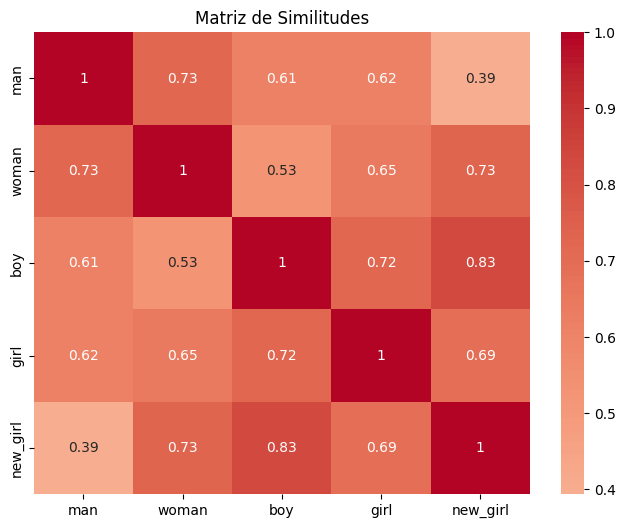

In [41]:
from sklearn.metrics import pairwise
# Definir las palabras de prueba
test_words = ['man', 'woman', 'boy', 'girl']

# Obtener los embeddings de las palabras
test_emb = np.array([w2v_amazon.wv[word] for word in test_words])

# Realizar la analogía: "girl" como "woman" - "man" + "boy"
new_girl = test_emb[1] - test_emb[0] + test_emb[2]  # woman - man + boy

# Añadir el nuevo vector a la lista de palabras
new_words = test_words + ['new_girl']
new_emb = np.append(test_emb, new_girl.reshape(1, -1), axis=0)

# Calcular la matriz de distancias usando la similitud coseno
dist = pairwise.cosine_similarity(new_emb)

# Convertir la matriz a un DataFrame para facilitar la visualización
similarity_df = pd.DataFrame(dist, index=new_words, columns=new_words)

# Imprimir la matriz de similitudes
print(similarity_df)

# Visualizar la matriz de similitudes
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Similitudes')
plt.show()

Conclusiones:

1) El primer dataset es uno de Twits de Twitter. El loss es alto luego de 20 epochs. Cuando queremos ver palabras relacionadas con outside por ejemplo, no encuentro alguna relación con el top 10.

2) Hacemos un test de analogías entre up, down, inside, outside y no se corrobora ni en el top 20.

3) El corpus es bastante chico, por lo que la red no está performando correctamente.

4) Entonces elijo un dataset mucho más grande, que es el de Amazon Revies. Le hago unas modificaciones para que sea más grande aún.

5) Aprnedizaje: Quise aumentar el tamaño del corpus con el dataset de Amazon, creyendo que podría ejecutar en GPU de colab (tengo colab pro por la materia VC II) y me daba un mensaje de que si bien tenía el entorno configurado para usar la GPU, no se estaba usando. Tras investigar, Gensim usa CPU y no es compatible con GPU, por lo que el entrenamiento con el dataset tardó más de una hora y media (inicialmente había colocado 50 epochs, lo bajé a 20)

6) El modelo overfittea en la epoch 5, en la cual corto el entrenamiento porque estaba tardando mucho.

7) Realizamos test de analogía con girl, boy, man, woman y sale correcto. La matriz de confusión muestra el mismo patrón donde hay más similitud de new_girl con boy que con girl o woman. Es similar a new_queen con king y queen en el ejemplo de la clase.

8) Veo el mapa de embeddings y encuentro woman, pero no veo man, que es el que está más relacionado con woman, con una similitud de 0.725. No sé si será porque se corta la cantidad de palabras de la nube.

Aclaraciones: el dataset de amazon es bastante pesado, dejo el link de drive por si querés usarlo desde mi drive, está compartido (a rodrigo.cardenas.sz@gmail.com) para que puedas acceder a la carpeta de datasets:  https://drive.google.com/drive/folders/1FZBly0X83AlqiAquIsuQ1KXCXi5M7X7l?usp=drive_link